In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output
from IPython import display
import gym
import pandas as pd
import gym_minigrid

import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
from tqdm import tqdm
from collections import defaultdict, deque
from random import random
from sklearn.preprocessing import MinMaxScaler
from minigrid_wrappers import CoordsObsWrapper, FourDirectionsActionWrapper, RewardWrapper
from utils import render, draw_square

# Getting Started with OpenAI Gym

## Interface

### Attributes
`action space`

`observation space`

### Methods
`def step`

`def reset`

`def render`

### Wrappers

## Gym Minigrid 
https://github.com/maximecb/gym-minigrid

## Example Minigrid Environments
<ol>
    <li>MiniGrid-Empty-8x8-v0</li>
    <li>MiniGrid-DistShift1-v0</li>
    <li>MiniGrid-DistShift2-v0</li>
    <li>MiniGrid-LavaCrossingS9N3-v0</li>
</ol>

Actions in the basic Minigrid environment:
<ol>
<li>Turn left</li>
<li>Turn right</li>
<li>Move forward</li>
<li>Pick up an object</li>
<li>Drop the object being carried</li>
<li>Toggle (open doors, interact with objects)</li>
<li>Done (task completed, optional)</li>
</ol>

In [2]:
env = gym.make("MiniGrid-DistShift1-v0") # create environment

In [3]:
env.action_space # action space of the environment

Discrete(7)

In [4]:
env.observation_space # observation space of the environment

Dict(image:Box(0, 255, (7, 7, 3), uint8))

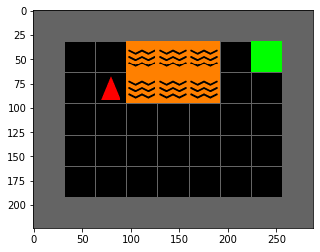

In [5]:
import time
obs = env.reset() # reset and get an initial observation

action = 0
for _ in range(10):
    action = env.action_space.sample() # sample a random action from the action space
    obs, reward, done, _ = env.step(action) # perform the action and receive an observation, reward, and if the episode is done
    render(env) # render the environment
    if done: # if the episode has terminated
        env.reset() # reset the environment
    time.sleep(0.5)

# Policy Evaluation

## Monte Carlo Policy Evaluation

TODO: explain monte carlo policy evaluation.
add notes, pictures, equations

In [ ]:
import warnings
warnings.filterwarnings('ignore')


def MCPE(episodes, env):
    returns = np.zeros((env.height, env.width))
    v_count = np.zeros((env.height, env.width))
    value_function = np.ones((env.height, env.width))*-2

    for i in tqdm(range(episodes), ncols=0):
        rewards = []
        states = []
        state = env.reset()
        done = False

        states.append(state)
        while not done:
            state, reward, done, _ = env.step(env.action_space.sample())
            states.append(state)
            rewards.append(reward)

        G = 0
        for state, reward in zip(states[:-1], rewards[::-1]):
            G += reward
            v_count[state] += 1
            returns[state] += G

        if i % 10 == 0:
            clear_output(wait=True)
            ax = sns.heatmap(value_function, cmap='RdYlGn', linewidth=1)
            plt.pause(0.00001)

        value_function = np.round(returns/v_count, 3)

    return np.round(returns/v_count, 3)

In [ ]:
env = gym.make("MiniGrid-DistShift1-v0") # create environment
env = CoordsObsWrapper(env) # wrap to get coordinates of agent as observation
env = FourDirectionsActionWrapper(env) # wrap to simplify action space (4 directional movement)
render(env)

In [ ]:
value_function = MCPE(1000, env)

In [ ]:
print(value_function)

## Temporal Difference Policy Evaluation

# Control

In [27]:
from matplotlib.colors import Normalize
normalize_qs = Normalize(vmin = -1, vmax = 1)

class Agent:
    """
    Base Agent class
    """
    def __init__(self,
                 env_name,
                 learning_rate=0.1,
                 eps_start = 1,
                 eps_end= 0.1,
                 eps_end_episode = 500,
                 episodes=1000,
                 gamma=0.95):
        self.action_space = ['right', 'down', 'left', 'up']
        self.env_name = env_name
        self.env = self.create_env(env_name)
        self.learning_rate = learning_rate
        self.mode = 'rgb'
        self.size = 32
        
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_end_episode = eps_end_episode        
        
        self.gamma = gamma
        self.episodes = episodes
        num_actions = self.env.action_space.n
        self.table = defaultdict(lambda: np.zeros(shape=(num_actions,)))
        self.rolling_mean = deque(np.zeros(shape=5), maxlen=5)
        self.rolling_mean_history = []
        self.epsilon_history = []
        
    def get_epsilon(self, episode):
        return max(self.eps_end, self.eps_start
              - (episode + 1) / self.eps_end_episode)
        
    def create_env(self, env_name):
        env = gym.make(env_name)
        env = RewardWrapper(env)
        env = CoordsObsWrapper(env)
        env = FourDirectionsActionWrapper(env)
        return env        

    def e_greedy(self, state, epsilon):
        if random() < epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.table[state])

    def train(self):
        raise NotImplementedError
        
    def plot(self):
#         print(self.table)
        clear_output(wait = True)   
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, 
                                            ncols=3,
                                            figsize=(15,5), 
                                            gridspec_kw={'width_ratios': [1, 1,1]})
        ax1.set_xlabel('Episodes')
        ax1.set_ylabel('Return')
        ax1.set_title('Return versus Episodes')
        ax1.plot(np.array(agent.rolling_mean_history))
        ax2.set_ylim(0, 1)
        ax2.set_xlabel('Episodes')
        ax2.set_ylabel('Epsilon')
        ax2.set_title('Epsilon versus Episodes')
        ax2.plot(self.epsilon_history)

        df_table = pd.DataFrame(self.table).T.reset_index()
        df_table.columns = ['y', 'x', 'right', 'down', 'left', 'up']
        df_table = df_table.sort_values(by=['y','x'])
        df_table['lb_x'] = df_table['x']*32
        df_table['lb_y'] = df_table['y']*32

#         df_table['right'] = MinMaxScaler().fit_transform(df_table['right'].values.reshape(-1,1)).reshape(-1)
#         df_table['down'] = MinMaxScaler().fit_transform(df_table['down'].values.reshape(-1,1)).reshape(-1)
#         df_table['left'] = MinMaxScaler().fit_transform(df_table['left'].values.reshape(-1,1)).reshape(-1)
#         df_table['up'] = MinMaxScaler().fit_transform(df_table['up'].values.reshape(-1,1)).reshape(-1)
        
        img = self.env.grid.render(tile_size=32)
#         img[img == 0] = 76
        ax3.imshow(img, interpolation='nearest')
        for row in df_table.itertuples():
            lb_y = row[-1]
            lb_x = row[-2]

            right = row[3]
            down = row[4]
            left = row[5]
            up = row[6]
                
            draw_square(lb_x, 
                        lb_y, 
                        self.size, 
                        alpha=1, 
                        r_color=normalize_qs(right),
                        b_color=normalize_qs(down),
                        l_color=normalize_qs(left),
                        t_color=normalize_qs(up))
        
        plt.pause(0.000001)
        
    def demo_plot(self, state):
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(15,5), gridspec_kw={'width_ratios': [2, 1]}) 
        img = self.env.render(mode='rgb')
        ax1.imshow(img, interpolation='nearest')
        plt.ylim(-0.1, 1)
        
        ax2.set_ylabel('Q-Values')
        ax2.set_title('Q-Values')
        sns.barplot(x=['right', 'down', 'left', 'up'], y=agent.table[state], ax = ax2)
        clear_output(wait = True)
        plt.pause(0.5)

    def demo(self, epsilon):
        print('Demo')
        done = False
        state = self.env.reset()
        for i in range(5):
            print(i)
            while not done:
                self.demo_plot(state)
                action = self.e_greedy(state,epsilon)
                next_state, reward, done, _ = self.env.step(action)
                self.rolling_mean.append(reward)
                state = next_state
#                 render(self.env)
            state = self.env.reset()
            done = False

## SARSA

Training a SARSA agent

TODO: add some notes, pictures, equations of SARSA

In [37]:
class AgentSarsa(Agent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def update_sarsa(self, action, state, next_state, next_action, reward, done):
        v_estimate = 0 if done else self.gamma*self.table[next_state][next_action]
        
        self.table[state][action] += self.learning_rate*(
            reward + v_estimate - self.table[state][action])

    def train(self):
        done = False
        state = self.env.reset()
        action = self.e_greedy(state, self.get_epsilon(0))

        episode_reward = 0
        for ep in range(self.episodes):
            epsilon = self.get_epsilon(ep)
            while not done:
                next_state, reward, done, _ = self.env.step(action)
                episode_reward += reward
                if not done:
                    next_action = self.e_greedy(next_state, epsilon)
                self.update_sarsa(action, state, next_state,
                                  next_action, reward, done)
                state = next_state
                action = next_action
            state = self.env.reset()
            action = self.e_greedy(state, epsilon)
            done = False
            self.rolling_mean.append(episode_reward)
            episode_reward = 0
            self.rolling_mean_history.append(np.mean(self.rolling_mean))
            self.epsilon_history.append(epsilon)
            if ep % 10 == 0:
                self.plot()

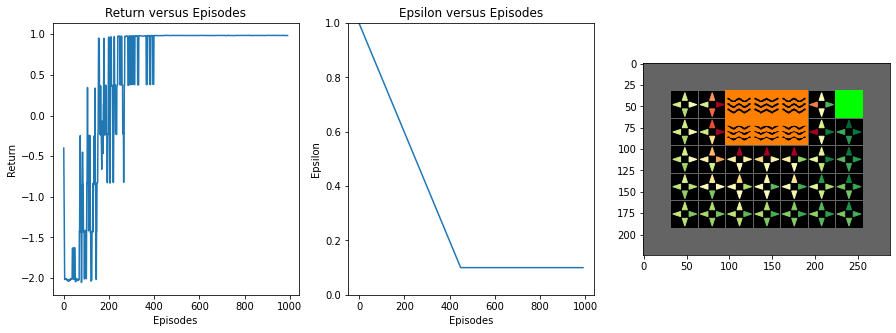

In [38]:
agent = AgentSarsa(env_name='MiniGrid-DistShift1-v0') #
agent.train()

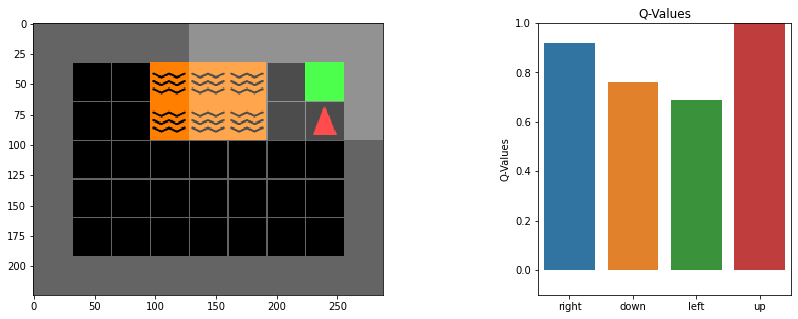

In [39]:
plt.close()
agent.demo(0)

## Q-learning

Training a Q-learning agent

//TODO:
add some notes and theory about Q-learning

In [34]:
class AgentQL(Agent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def update_q_table(self, action, state, next_state, reward, done):
        v_estimate = 0 if done else self.gamma*np.max(self.table[next_state])
        self.table[state][action] += self.learning_rate*(
            reward + v_estimate - self.table[state][action])

    def train(self):
        done = False
        state = self.env.reset()
        step = 0
        episode_reward = 0
        for ep in range(self.episodes):
            epsilon = self.get_epsilon(ep)
            while not done:
                action = self.e_greedy(state, epsilon)
                next_state, reward, done, _ = self.env.step(action)
                episode_reward += reward
                self.update_q_table(action, state, next_state, reward, done)
                state = next_state
                step += 1
            state = self.env.reset()
            done = False
            self.rolling_mean.append(episode_reward)
            episode_reward = 0
            self.rolling_mean_history.append(np.mean(self.rolling_mean))
            self.epsilon_history.append(epsilon)
            if ep % 10 ==0:
                self.plot()

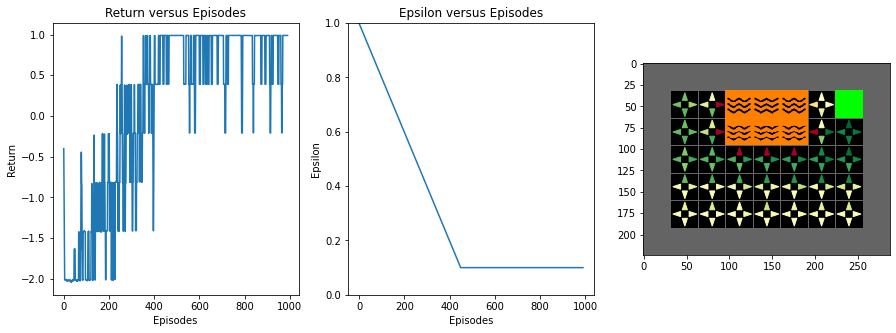

In [35]:
agent = AgentQL(env_name='MiniGrid-DistShift1-v0')
agent.train()

In [ ]:
qlearning_rolling_mean = agent.rolling_mean_history

In [ ]:
sns.distplot(sarsa_rolling_mean, label='SARSA')
sns.distplot(qlearning_rolling_mean, label= 'Q-Learning')
plt.legend()
plt.show()

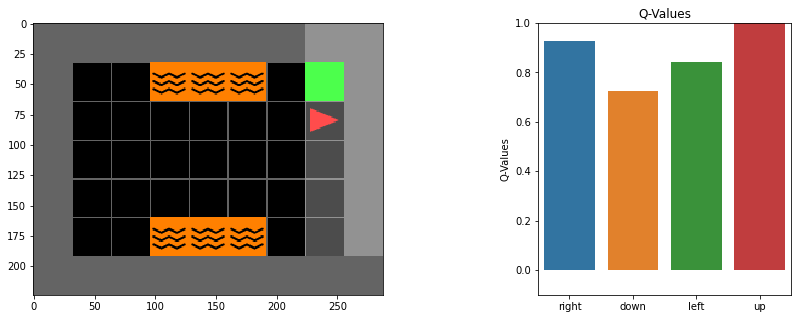

In [32]:
agent.demo(0)

## Tetris

In [ ]:
from nes_py.wrappers import JoypadSpace
import gym_tetris
from gym_tetris.actions import MOVEMENT
import gym

env = gym.make('TetrisA-v0')
env = JoypadSpace(env, MOVEMENT)

print(env.observation_space)
print(env.action_space)

done = True
for step in range(5000):
    if done:
        state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    render(env, mode='rgb_array')

env.close()

In [ ]:
plt.imshow(state, interpolation='nearest')